# Fitting the AR GRCH model to NAV data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load the NAV data
df = pd.read_csv("NAV.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df = df.set_index('Date')
df.head()

,NAV
Date,
2001-01-01,100.00
2001-01-02,97.20
2001-01-03,102.25
2001-01-04,101.16
2001-01-05,98.51


Number of observations: 4025

Returns Statistics:
count    4025.000000
mean        0.036262
std         1.230328
min        -8.604605
25%        -0.492914
50%         0.064041
75%         0.585329
max        12.197012
Name: returns, dtype: float64


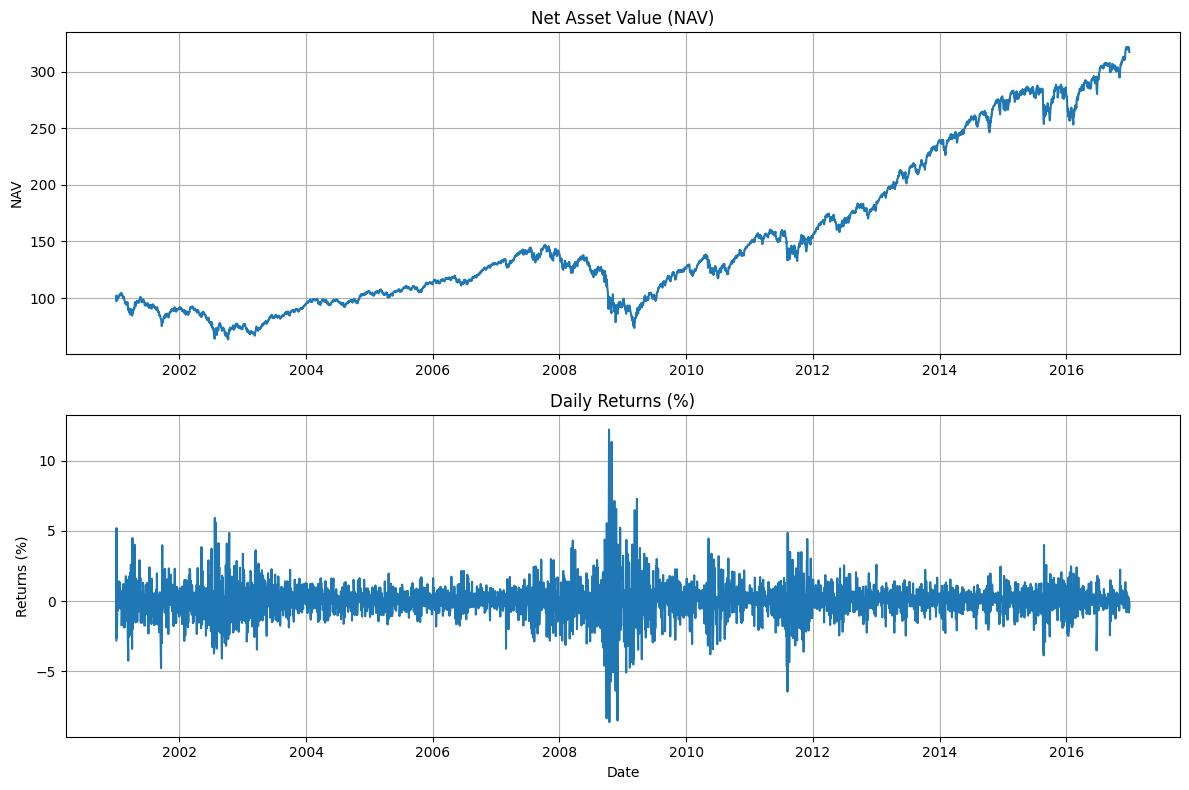

In [6]:
# Calculate returns (percentage returns)
df['returns'] = df['NAV'].pct_change() * 100
df = df.dropna()

print(f"Number of observations: {len(df)}")
print(f"\nReturns Statistics:")
print(df['returns'].describe())

# Plot NAV and returns
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(df.index, df['NAV'])
axes[0].set_title('Net Asset Value (NAV)')
axes[0].set_ylabel('NAV')
axes[0].grid(True)

axes[1].plot(df.index, df['returns'])
axes[1].set_title('Daily Returns (%)')
axes[1].set_ylabel('Returns (%)')
axes[1].set_xlabel('Date')
axes[1].grid(True)
plt.tight_layout()
plt.show()


In [7]:
# Fit AR(1)-GARCH(1,1) model
# The mean parameter 'AR' specifies an autoregressive model for the mean
# The vol parameter 'GARCH' specifies a GARCH model for the variance
model = arch_model(df['returns'], mean='AR', lags=1, vol='GARCH', p=1, q=1)
results = model.fit(disp='off')


In [8]:
# ============================================================================
# AR(1)-GARCH(1,1) MODEL ESTIMATION RESULTS - FORMATTED FOR REPORT
# ============================================================================

print("="*80)
print(" " * 20 + "AR(1)-GARCH(1,1) MODEL ESTIMATION RESULTS")
print("="*80)
print(f"\nDependent Variable: NAV Returns (%)")
print(f"Sample Period: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of Observations: {len(df)}")
print(f"Distribution: Normal")
print("\n" + "-"*80)

# Create a clean parameter table
summary_data = []
for param_name in results.params.index:
    summary_data.append({
        'Parameter': param_name,
        'Coefficient': f"{results.params[param_name]:.6f}",
        'Std. Error': f"{results.std_err[param_name]:.6f}",
        't-statistic': f"{results.tvalues[param_name]:.4f}",
        'P-value': f"{results.pvalues[param_name]:.6f}"
    })

summary_df = pd.DataFrame(summary_data)

# Print the mean equation
print("\nMEAN EQUATION (AR(1)):")
print("-"*80)
mean_params = summary_df[summary_df['Parameter'].isin(['mu', 'returns[1]'])]
print(mean_params.to_string(index=False))

# Print the variance equation
print("\n\nVOLATILITY EQUATION (GARCH(1,1)):")
print("-"*80)
vol_params = summary_df[summary_df['Parameter'].isin(['omega', 'alpha[1]', 'beta[1]'])]
print(vol_params.to_string(index=False))

# Model diagnostics
print("\n\nMODEL DIAGNOSTICS:")
print("-"*80)
print(f"Log-Likelihood:          {results.loglikelihood:.4f}")
print(f"AIC:                     {results.aic:.4f}")
print(f"BIC:                     {results.bic:.4f}")

# Additional statistics
persistence = results.params['alpha[1]'] + results.params['beta[1]']
uncond_var = results.params['omega'] / (1 - persistence)
half_life = np.log(0.5) / np.log(persistence)

print("\n\nVOLATILITY PERSISTENCE:")
print("-"*80)
print(f"Persistence (α₁ + β₁):   {persistence:.6f}")
print(f"Unconditional Variance:  {uncond_var:.6f}")
print(f"Half-Life (days):        {half_life:.2f}")

print("\n" + "="*80)
print("\nNote: *** p<0.01, ** p<0.05, * p<0.1")
print("="*80)


                    AR(1)-GARCH(1,1) MODEL ESTIMATION RESULTS

Dependent Variable: NAV Returns (%)
Sample Period: 2001-01-02 to 2016-12-30
Number of Observations: 4025
Distribution: Normal

--------------------------------------------------------------------------------

MEAN EQUATION (AR(1)):
--------------------------------------------------------------------------------
 Parameter Coefficient Std. Error t-statistic  P-value
returns[1]   -0.062449   0.016217     -3.8509 0.000118


VOLATILITY EQUATION (GARCH(1,1)):
--------------------------------------------------------------------------------
Parameter Coefficient Std. Error t-statistic  P-value
    omega    0.021781   0.005177      4.2070 0.000026
 alpha[1]    0.102039   0.012576      8.1140 0.000000
  beta[1]    0.879298   0.013544     64.9192 0.000000


MODEL DIAGNOSTICS:
--------------------------------------------------------------------------------
Log-Likelihood:          -5578.5356
AIC:                     11167.0711
BIC:   

In [9]:
# Alternative: Display as a styled DataFrame (cleaner for screenshots)
import warnings
warnings.filterwarnings('ignore')

# Create comprehensive results table
results_dict = {
    'Parameter': [],
    'Estimate': [],
    'Std. Error': [],
    't-stat': [],
    'P-value': [],
    'Significance': []
}

for param in results.params.index:
    results_dict['Parameter'].append(param)
    results_dict['Estimate'].append(results.params[param])
    results_dict['Std. Error'].append(results.std_err[param])
    results_dict['t-stat'].append(results.tvalues[param])
    pval = results.pvalues[param]
    results_dict['P-value'].append(pval)
    
    # Add significance stars
    if pval < 0.01:
        sig = '***'
    elif pval < 0.05:
        sig = '**'
    elif pval < 0.1:
        sig = '*'
    else:
        sig = ''
    results_dict['Significance'].append(sig)

results_table = pd.DataFrame(results_dict)

# Style the table
styled_table = results_table.style\
    .format({
        'Estimate': '{:.6f}',
        'Std. Error': '{:.6f}',
        't-stat': '{:.4f}',
        'P-value': '{:.4f}'
    })\
    .set_properties(**{
        'text-align': 'center',
        'font-size': '11pt'
    })\
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#2c3e50'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('font-size', '12pt'),
            ('padding', '10px')
        ]},
        {'selector': 'td', 'props': [
            ('padding', '8px'),
            ('border', '1px solid #ddd')
        ]},
        {'selector': 'tr:nth-of-type(even)', 'props': [
            ('background-color', '#f9f9f9')
        ]},
        {'selector': '', 'props': [
            ('border-collapse', 'collapse'),
            ('margin', '25px 0'),
            ('font-family', 'Arial, sans-serif'),
            ('box-shadow', '0 0 20px rgba(0, 0, 0, 0.15)')
        ]}
    ])

display(styled_table)

# Display model statistics below
print("\n" + "="*70)
print("MODEL INFORMATION")
print("="*70)
print(f"Model Specification:     AR(1)-GARCH(1,1)")
print(f"Distribution:            Normal")
print(f"Number of Observations:  {len(df)}")
print(f"Sample Period:           {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nLog-Likelihood:          {results.loglikelihood:.4f}")
print(f"AIC:                     {results.aic:.4f}")
print(f"BIC:                     {results.bic:.4f}")
persistence = results.params['alpha[1]'] + results.params['beta[1]']
print(f"\nVolatility Persistence:  {persistence:.6f}")
print("="*70)
print("Significance: *** p<0.01, ** p<0.05, * p<0.1")
print("="*70)


,Parameter,Estimate,Std. Error,t-stat,P-value,Significance
0,Const,0.069189,0.013324,5.1927,0.0000,***
1,returns[1],-0.062449,0.016217,-3.8509,0.0001,***
2,omega,0.021781,0.005177,4.2070,0.0000,***
3,alpha[1],0.102039,0.012576,8.1140,0.0000,***
4,beta[1],0.879298,0.013544,64.9192,0.0000,***



MODEL INFORMATION
Model Specification:     AR(1)-GARCH(1,1)
Distribution:            Normal
Number of Observations:  4025
Sample Period:           2001-01-02 to 2016-12-30

Log-Likelihood:          -5578.5356
AIC:                     11167.0711
BIC:                     11198.5713

Volatility Persistence:  0.981337
Significance: *** p<0.01, ** p<0.05, * p<0.1


In [10]:
# Extract model parameters
print("=" * 70)
print("MODEL PARAMETERS")
print("=" * 70)
print(f"\nMean Equation (AR(1)):")
print(f"  Constant (μ): {results.params['mu']:.6f}")
print(f"  AR(1) coefficient (φ₁): {results.params['returns[1]']:.6f}")

print(f"\nVolatility Equation (GARCH(1,1)):")
print(f"  Constant (ω): {results.params['omega']:.6f}")
print(f"  ARCH(1) coefficient (α₁): {results.params['alpha[1]']:.6f}")
print(f"  GARCH(1) coefficient (β₁): {results.params['beta[1]']:.6f}")

# Calculate persistence
persistence = results.params['alpha[1]'] + results.params['beta[1]']
print(f"\nPersistence (α₁ + β₁): {persistence:.6f}")
print(f"Unconditional variance: {results.params['omega'] / (1 - persistence):.6f}")


MODEL PARAMETERS

Mean Equation (AR(1)):


KeyError: 'mu'

In [ ]:
# Plot conditional volatility
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Returns
axes[0].plot(df.index, df['returns'])
axes[0].set_title('Daily Returns (%)')
axes[0].set_ylabel('Returns (%)')
axes[0].grid(True)

# Conditional volatility
axes[1].plot(results.conditional_volatility)
axes[1].set_title('Conditional Volatility (from AR(1)-GARCH(1,1))')
axes[1].set_ylabel('Volatility')
axes[1].grid(True)

# Standardized residuals
axes[2].plot(results.std_resid)
axes[2].set_title('Standardized Residuals')
axes[2].set_ylabel('Std. Residuals')
axes[2].set_xlabel('Date')
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Diagnostic plots
fig = plt.figure(figsize=(12, 8))
results.plot(annualize='D')
plt.tight_layout()
plt.show()


In [ ]:
# Forecasting
# Generate 10-step ahead forecast
forecasts = results.forecast(horizon=10)
print("=" * 70)
print("FORECAST (Next 10 periods)")
print("=" * 70)
print("\nMean Forecast:")
print(forecasts.mean.iloc[-1])
print("\nVariance Forecast:")
print(forecasts.variance.iloc[-1])
